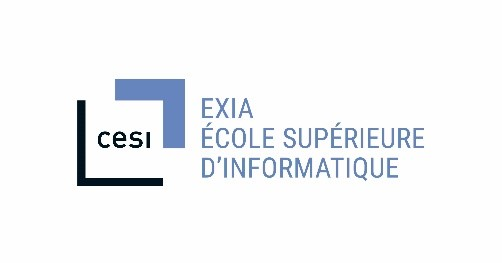


# **Livrable 01 - Classification (PHASE 1)**

#### **Membre du groupe**

*   Zinedine Ait Rabah Djaafer
*   Soltane Benghezal
*   Fares Mounir Merzouk
*   Ghada Messaour
####  **Chef de groupe** 
*   Abdelhamid Larachi

#### **Pilote de Formation : Mr. Fayçal Khetar**
#### **Pilote de l'option : Mr. Hani Afrit**
---





 




# **Description du livrable**

Le livrable sera sous la forme notebook Jupyter et devra, pour être validé, intégrer :

    Le code TensorFlow ainsi qu'un schéma de l'architecture du réseau de neurones. Toutes les parties doivent être détaillées dans le notebook : les paramètres du réseau, la fonction de perte ainsi que l'algorithme d'optimisation utilisé pour l’entraînement.

    Un graphique contenant l'évolution de l'erreur d’entraînement ainsi que de l'erreur de test et l'évolution de l'accuracy pour ces deux datasets.

    L'analyse de ces résultats, notamment le compromis entre biais et variance (ou sur-apprentissage et sous-apprentissage).

    Une description des méthodes potentiellement utilisables pour améliorer les compromis biais/variance : technique de régularisation, drop out, early-stopping, ...

Plusieurs datasets sont à votre disposition. On a :

    Des peintures

    Des Schéma et graphes

    Des portraits dessinés en noir et blanc

    Des images de textes scannés

    Des photos

 

Le but ultime est d'être capable de distinguer les photos parmi toutes ces images. Il est tout de même conseillé de commencer par les images les plus faciles à distinguer des photos, puis aller vers les dataset les plus difficiles à classifier (notamment, il y a dans le dataset peinture un certain nombre d'œuvres au rendu assez réaliste, qui devraient nous poser problème).

**Importer TensorFlow et d'autres bibliothèques**

---



In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import random
from imageio import imread
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model

**Télécharger et explorer l'ensemble des données**

---

Dans ce fichier, nous allons utiliser un jeu de données de divers images.
Le jeu de données contient cinq sous-répertoires, un par classe :

```
Images/
  Painting/
  Photo/
  Schematics/
  Sketch/
  Text/
```

In [1]:
import pathlib

data_dir = r'/Users/nginx-iwnl/Documents/aiProject/dataset'
data_dir = pathlib.Path(data_dir)

Après le téléchargement, nous devrons disposer d'une copie de l'ensemble de données. Il y a 41 406 images au total :

In [2]:
image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)

41405


Voici quelques photos :

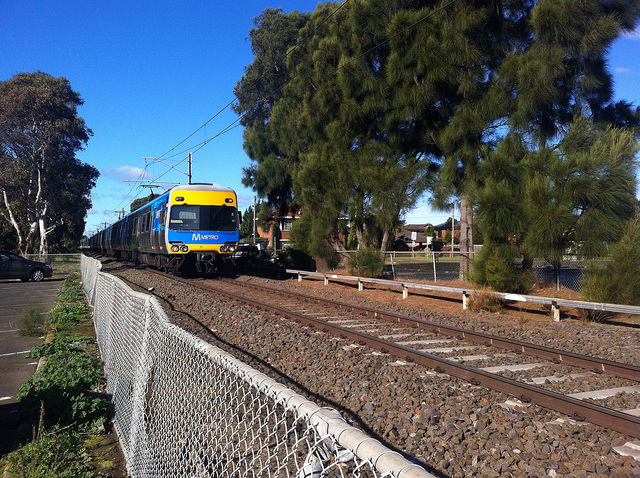

In [ ]:
photos = list(data_dir.glob('Photo/*'))
PIL.Image.open(str(photos[0]))

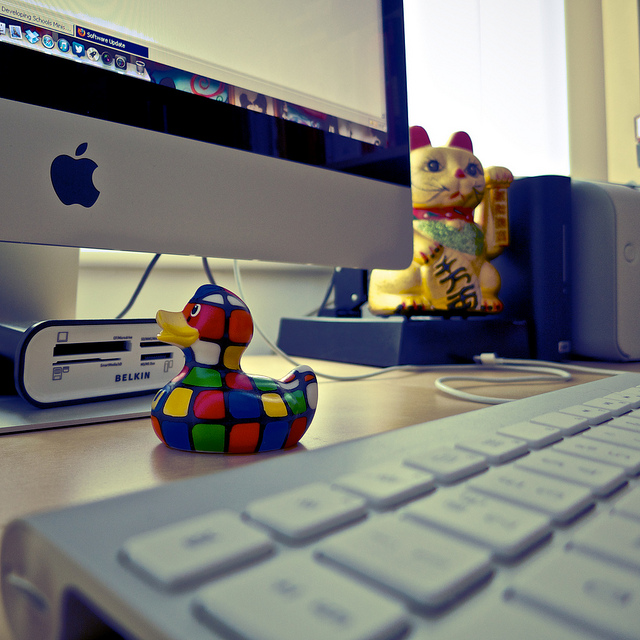

In [ ]:
PIL.Image.open(str(photos[4]))

quelques peintures :

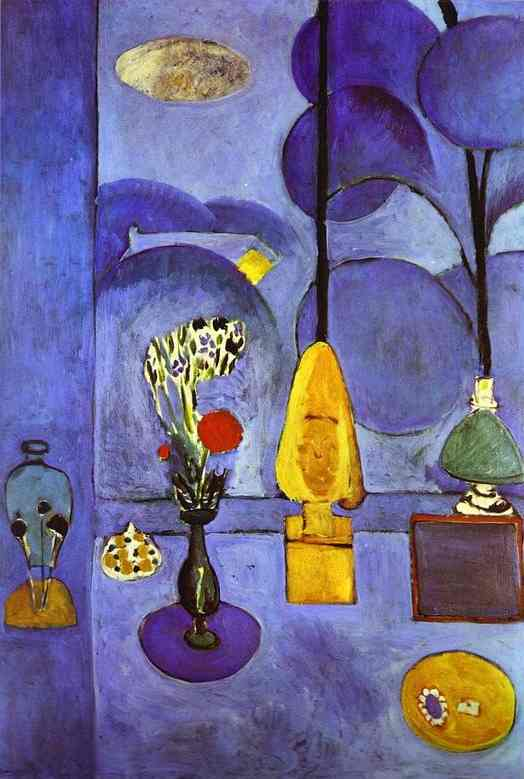

In [ ]:
painting = list(data_dir.glob('Painting/*'))
PIL.Image.open(str(painting[711]))

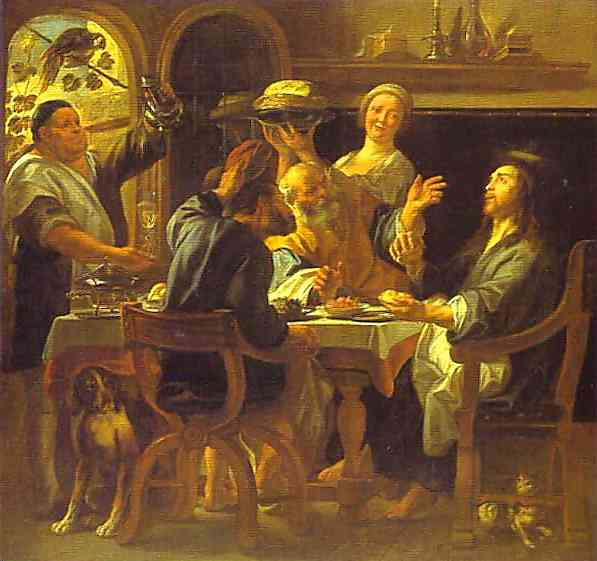

In [ ]:
PIL.Image.open(str(painting[1]))

**Chargement des données à l'aide d'un utilitaire Keras**
---

Pour pouvoir exploiter le dataset, nous allons devoir charger les images depuis le disque en utilisant la fonction `tf.keras.utils.image_dataset_from_directory`. Cela va nous permettre de passer d'un répertoire d'images sur le disque à un `tf.data.Dataset` en seulement quelques lignes de code.

## **Créer un ensemble de données**

---



Définir quelques paramètres pour le loader :

In [4]:
batch_size = 32
img_height = 180
img_width = 180

C'est une bonne pratique d'utiliser un fractionnement de validation lors du développement de notre modèle. Réservons 80 % des images pour l'entraînement et 20 % pour la validation.

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 41405 files belonging to 5 classes.
Using 33124 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 41405 files belonging to 5 classes.
Using 8281 files for validation.


Comme nous le savons, notre dataset est composé de repoeroires qui contiennent des images. Nous pouvons afficher les noms de ces repertoires `class_names` qui representent les labels des images qu'ils contiennent.La suite ci-dessous correspond aux noms des répertoires par ordre alphabétique.

In [7]:
class_names = train_ds.class_names
print(class_names)

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


## **Visualiser les données**

---



Voici les neuf premières images de l'ensemble de données d'entraînement :

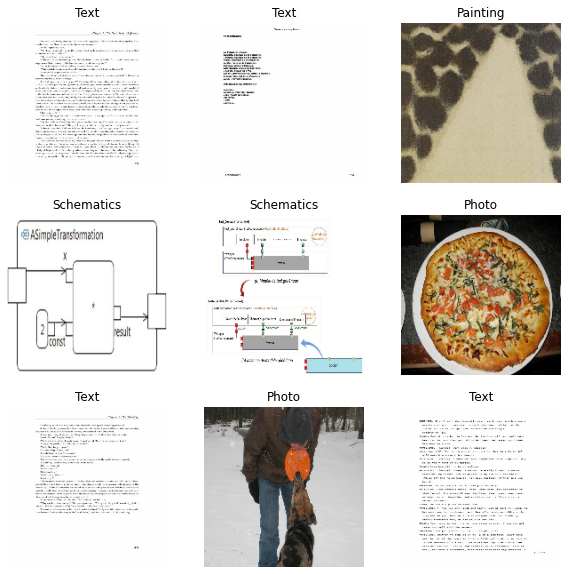

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Nous allons former un modèle à l'aide de ces ensembles de données en les passant à `Model.fit` dans un instant. Si nous le souhaitons, nous pouvons également itérer manuellement sur le jeu de données et récupérer des lots d'images :

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Le lot d'images est un tenseur de la forme (32, 180, 180, 3). Il s'agit d'un lot de 32 images de forme 180x180x3 (la dernière dimension fait référence aux canaux de couleur RGB). Le lot `label_batch` est un tenseur de la forme (32,), ce sont les étiquettes correspondantes aux 32 images.

On peut appeler `.numpy()` sur les tenseurs `image_batch` et `labels_batch` pour les convertir en un `numpy.ndarray`.

## **Configurer l'ensemble de données pour la performance**

---



Veillons à utiliser la préextraction en mémoire tampon afin de pouvoir céder des données depuis le disque sans que les E/S ne deviennent bloquantes. Ce sont deux méthodes importantes que nous devrons utiliser lors du chargement des données :

- `Dataset.cache` garde les images en mémoire après qu'elles aient été chargées depuis le disque pendant la première époque. Cela permet de s'assurer que le jeu de données ne devient pas un goulot d'étranglement lors de l'entraînement de votre modèle. Si votre jeu de données est trop grand pour tenir en mémoire, on peut également utiliser cette méthode pour créer un cache performant sur le disque.
- `Dataset.prefetch` chevauche le prétraitement des données et l'exécution du modèle pendant l'entraînement.

Les lecteurs intéressés peuvent en savoir plus sur ces deux méthodes, ainsi que sur la façon de mettre les données en cache sur le disque dans la section *Prefetching* du guide [Better performance with the tf.data API](../../guide/data_performance.ipynb).


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# *Créer le modéle*

---

avant de créer le modèle, on passera par un petit rappel:

**Qu'est-ce qu'un réseau de neurones convolutifs ?**

Un réseau de neurones convolutifs est un puissant réseau de neurones qui utilise des filtres pour extraire les caractéristiques des images. Il le fait également de telle manière que les informations de position des pixels soient conservées.

**Les différentes couches de CNN**

Il existe quatre types de couches pour un réseau de neurones convolutif :

*   **la couche de convolution** : Les couches convolutives sont les couches où les filtres sont appliqués à l'image d'origine ou à d'autres cartes de caractéristiques dans un CNN profond.

*   **la couche de pooling** : Les couches de pooling sont similaires aux couches convolutives, mais elles remplissent une fonction spécifique telle que le pooling maximal, qui prend la valeur maximale dans une certaine région de filtre, ou le pooling moyen, qui prend la valeur moyenne dans une région de filtre. Ceux-ci sont généralement utilisés pour réduire la dimensionnalité du réseau.

*   la couche de correction ReLU
*   **la couche fully connected** : Les couches entièrement connectées sont placées avant la sortie de classification d'un CNN et sont utilisées pour aplatir les résultats avant la classification. Ceci est similaire à la couche de sortie d'un MLP.

**Présentation de Relu**

La non-linéarité la plus réussie pour les CNN est l'unité non linéaire rectifiée (ReLU), qui combat le problème de gradient de fuite survenant dans les sigmoïdes. ReLU est plus facile à calculer et génère de la parcimonie (pas toujours bénéfique).


Le modèle [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) consiste en trois blocs de convolution (`tf.keras.layers.Conv2D`) avec une couche de pooling max (`tf.keras.layers.MaxPooling2D`) dans chacun d'eux. Il y a une couche entièrement connectée (`tf.keras.layers.Dense`) avec 128 unités au sommet qui est activée par une fonction d'activation ReLU (`'relu'`).

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## **Compiler le model**

---



Maintenant, nous choisissons l'optimiseur `tf.keras.optimizers.Adam` et la fonction de perte `tf.keras.losses.SparseCategoricalCrossentropy` pour la compilation du modèle. Pour afficher la précision de l'apprentissage et de la validation pour chaque époque d'apprentissage, nous passons l'argument `metrics` à `Model.compile`.
Les métriques définissent les paramètres des données que nous allons utiliser pour mesurer les performances.
Model.compile aide à compiler un modèle de keras.


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## **Résumé du modèle et Shéma**

---


Affichons maintenant toutes les couches du réseau en utilisant la méthode `Model.summary` du modèle :

In [8]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

Nous pouvons également avoir une representation graphique du modele grace à la fonction `plot_model` pour mieux visualiser les couche de notre modele :

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

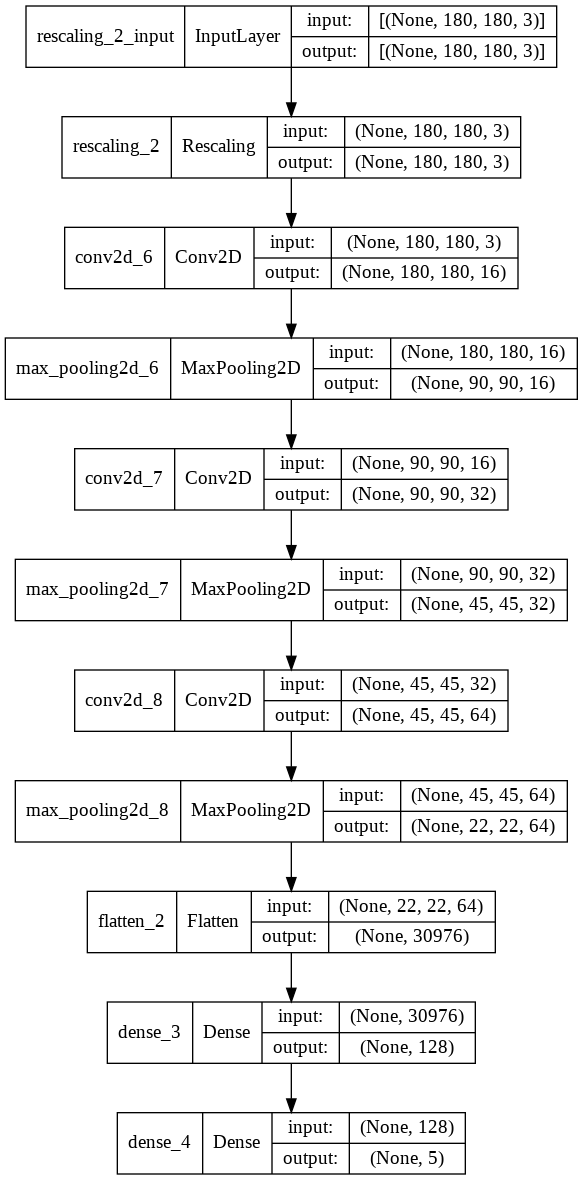

## **Entraîner le modèle**

---



In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1036/1036 [==============================] - 280s 226ms/step - loss: 0.5658 - accuracy: 0.7666 - val_loss: 0.3763 - val_accuracy: 0.8532
Epoch 2/10
1036/1036 [==============================] - 238s 230ms/step - loss: 0.3261 - accuracy: 0.8713 - val_loss: 0.3282 - val_accuracy: 0.8628
Epoch 3/10
1036/1036 [==============================] - 237s 229ms/step - loss: 0.2435 - accuracy: 0.9022 - val_loss: 0.3291 - val_accuracy: 0.8818
Epoch 4/10
1036/1036 [==============================] - 238s 229ms/step - loss: 0.1792 - accuracy: 0.9315 - val_loss: 0.3457 - val_accuracy: 0.8708
Epoch 5/10
1036/1036 [==============================] - 239s 230ms/step - loss: 0.1226 - accuracy: 0.9533 - val_loss: 0.3472 - val_accuracy: 0.8861
Epoch 6/10
1036/1036 [==============================] - 238s 230ms/step - loss: 0.0795 - accuracy: 0.9714 - val_loss: 0.3967 - val_accuracy: 0.8899
Epoch 7/10
1036/1036 [==============================] - 238s 230ms/step - loss: 0.0597 - accuracy: 0.9797 - val_

## **Visualiser les résultats de l'apprentisage**

---



Nous allons créer des graphiques pour visualiser le "loss" et l'"accuracy" sur les ensembles d'entrainement et de validation :

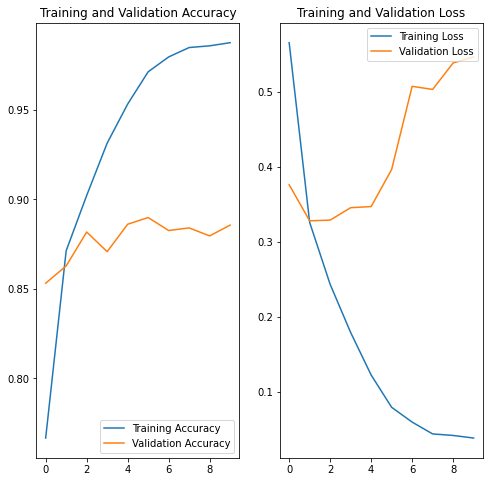

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Les graphiques montrent que la précision de la formation et celle de la validation sont très éloignées l'une de l'autre, vérifions ce qui n'a pas fonctionné et essayons d'améliorer la performance globale du modèle.

Dans les graphiques ci-dessus, la précision de la formation augmente linéairement au fil du temps. De plus, la différence de précision entre la précision de formation et la précision de validation est notable - un signe d'overfitting


## **Overfitting**

---



Lorsqu'il y a un petit nombre d'exemples d'entrainement, le modèle apprend parfois des bruits ou des détails indésirables, à tel point que cela a un impact négatif sur les performances du modèle sur les nouveaux exemples. Ce phénomène est connu sous le nom d'overfitting. Il signifie que le modèle aura du mal à se généraliser sur un nouvel ensemble de données.




# **Régularisation**

---


Un modèle de Deep Learning doit à la fois optimiser son entraînement et généraliser sa prédiction à l’ensemble des données. Un outil est là pour ça : la Regularization.

La Regularization est un ensemble de méthode qui permet à la fois d’optimiser l’apprentissage d’un modèle de Deep Learning et de contrer l’overfitting (manque de généralisation).
La Regularization Weight Decay, en français Diminution des Poids permet d’améliorer la généralisation lors de l’apprentissage du modèle.
Le but du Weight Decay est de diminuer la valeur des poids trop important.

C’est une sorte de handicap que l’on donne au poids qui augmentent trop vite. Grâce à cet handicap, le modèle doit performer ailleurs que sur les neurones associés à ces poids. Ainsi, d’autres poids vont pouvoir progresser pour transmettre de l’information.

En pratique, la Regularization s’effectue après avoir calculé la focntion loss. on applique la fonction de régularisation qui:


*   pour la L1-Regularization la somme des poids en valeur absolue multiplié par une constante α
*   pour la L2-Regularization la somme des poids au carré multiplié par une constante α

L'avantage des deux techniquement:


*   L1-Regularization permet d’effectuer une feature selection plus précise (trouver des sous-ensembles de données pertinents)
*   L2-Regularization permet d’effectuer un apprentissage plus rapide









## **Data augmentation**

---



L'augmentation des données se produit généralement lorsque le nombre d'exemples d'apprentissage est faible. [L'augmentation des données](./data_augmentation.ipynb) consiste à générer des données d'apprentissage supplémentaires à partir des exemples existants en les augmentant à l'aide de transformations aléatoires qui produisent des images d'apparence crédible. Cela permet d'exposer le modèle à davantage d'aspects des données et de mieux les généraliser.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## **Dropout**

---



Une autre technique permettant de réduire l'overfitting consiste à introduire une régularisation [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) dans le réseau.

Créons un nouveau réseau neuronal avec `tf.keras.layers.Dropout` avant de l'entraîner en utilisant les images augmentées :

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## **Compiler et entrainer le modèle**

---



In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

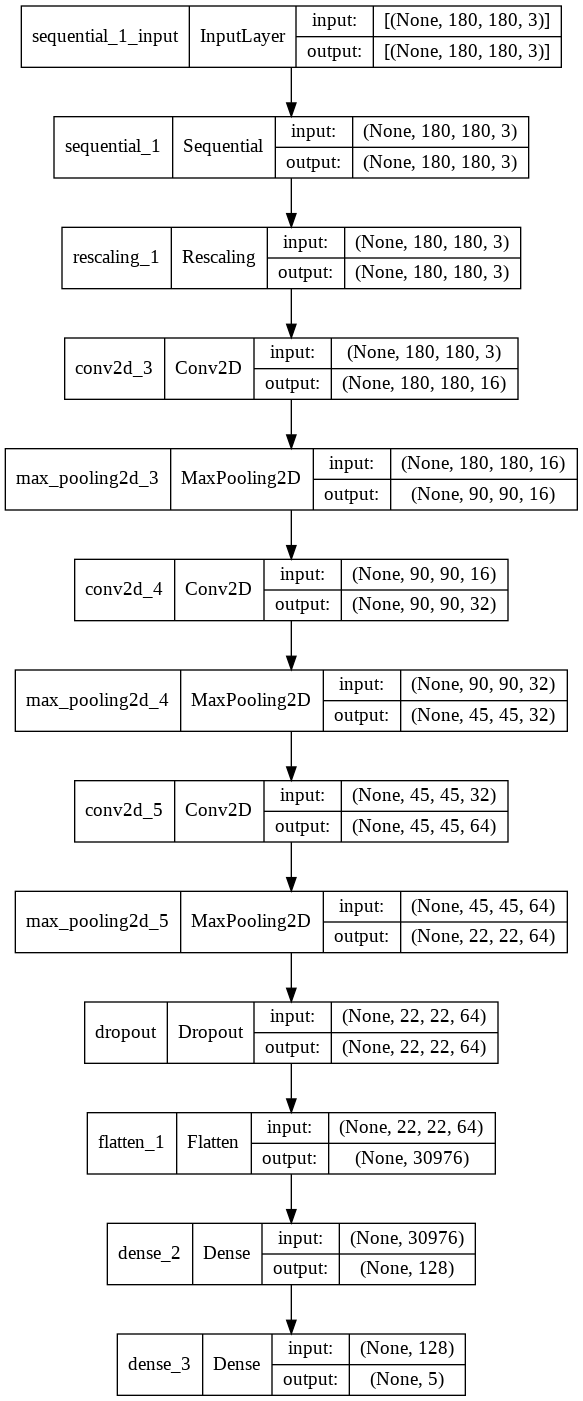

In [10]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
1036/1036 [==============================] - 277s 267ms/step - loss: 0.5771 - accuracy: 0.7527 - val_loss: 0.4324 - val_accuracy: 0.8290
Epoch 2/15
1036/1036 [==============================] - 274s 265ms/step - loss: 0.3953 - accuracy: 0.8383 - val_loss: 0.3611 - val_accuracy: 0.8632
Epoch 3/15
1036/1036 [==============================] - 274s 264ms/step - loss: 0.3432 - accuracy: 0.8620 - val_loss: 0.3550 - val_accuracy: 0.8640
Epoch 4/15
1036/1036 [==============================] - 274s 265ms/step - loss: 0.3121 - accuracy: 0.8772 - val_loss: 0.2803 - val_accuracy: 0.8923
Epoch 5/15
1036/1036 [==============================] - 274s 265ms/step - loss: 0.2859 - accuracy: 0.8878 - val_loss: 0.3190 - val_accuracy: 0.8813
Epoch 6/15
1036/1036 [==============================] - 274s 265ms/step - loss: 0.2763 - accuracy: 0.8907 - val_loss: 0.3548 - val_accuracy: 0.8721
Epoch 7/15
1036/1036 [==============================] - 277s 267ms/step - loss: 0.2592 - accuracy: 0.8988 - val_

#### **Sauvegarder notre modèle**


In [ ]:
model.save("classification_modal.h5")

#### **Télécharger notre modèle**


In [8]:
model = keras.models.load_model("classification_modal.h5")

## **Visualiser les résultats de l'apprentissage**

---



Après avoir appliqué l'augmentation des données et `tf.keras.layers.Dropout`, il y a moins de sur-apprentissage qu'avant, et la précision de l'entraînement et de la validation sont plus proches :

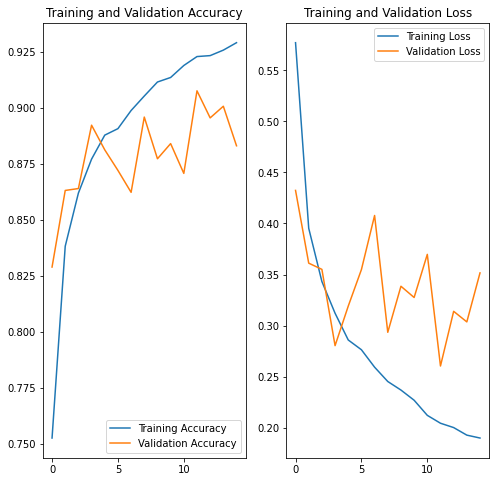

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Analyse du comportement de l'algorithme**

Aprés avoir parametré le modele dans le but d'obtenir une meilleure précision et une perte moins conséquente, nous remarquons que le sur-apprentissage affecte considerblement l'entrainement des neuronnes. Comme definit precedement, un modele sur-entrainé generera un resultat trés concluant sur le trainings_set mais deffectueux sur le validation_set. Le fait d'avoir eliminé des neuronnes avec la technique du Dropout, a permis aux neuronnes les moins précis de s'entrainer d'avantage et ainsi faire de meilleures pédictions. Le Data Augmentation a egalement permis aux neuronnes de s'entrainer sur un data_set amélioré et d'apprendre plus de parametres.


## **Prédire sur de nouvelles données**

---



Enfin, utilisons notre modèle pour classer une image qui n'était pas incluse dans les ensembles d'entrainement ou de validation.

*Note : Les couches d'augmentation et de suppression des données sont inactives au moment de l'inférence.*

In [40]:
# Random Photo Image url
PhotoURL = "https://www.cnet.com/a/img/-qQkzFVyOPEoBRS7K5kKS0GFDvk=/940x0/2020/04/16/7d6d8ed2-e10c-4f91-b2dd-74fae951c6d8/bazaart-edit-app.jpg"

# Random Painting Image url
PaintingURL = "https://4.imimg.com/data4/WM/XJ/ANDROID-49266283/product-500x500.jpeg"

# Random Schematic Image url
SchematicURL = "https://s3.ap-south-1.amazonaws.com/afteracademy-server-uploads/what-is-schema-diagram-b8915aa44db73ede.jpg"

# Random Sketch Image url
SketchURL = "https://i.pinimg.com/474x/03/7c/cf/037ccfd7f82827ae8c4cae86c7f3fb99.jpg"

# Random Text Image url
TextURL = "https://media.cheggcdn.com/study/b08/b08161c4-5061-4b8d-9be8-6435541a5fc2/image"

In [35]:
def isPhoto(url):
    # Display photo
    image = imread(url)
    plt.imshow(image)
    plt.show()
    
    # REPLACE ORIGIN PARAM
    image = tf.keras.utils.get_file(origin=url)
    img = tf.keras.utils.load_img(image, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print("\n\nThis image most likely belongs to \033[94m{} with a {:.2f} percent confidence.\033[0m"
    .format(class_names[np.argmax(score)], 100 * np.max(score)))
    
    
    # Binary Classification
    print (np.argmax(score) == 1 and ('This image\033[94m is a Photo \033[0m') or 'This image\033[94m is not a Photo \033[0m')

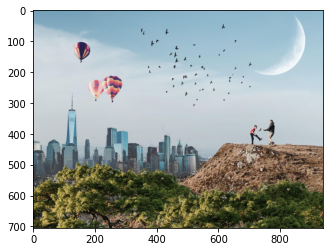



This image most likely belongs to Photo with a 96.55 percent confidence.
This image is a Photo 


In [36]:
isPhoto(PhotoURL)

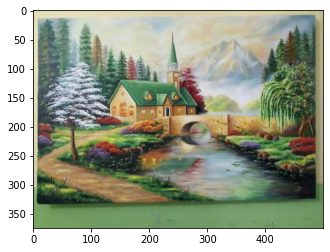



This image most likely belongs to Painting with a 89.27 percent confidence.
This image is not a Photo 


In [42]:
isPhoto(PaintingURL)

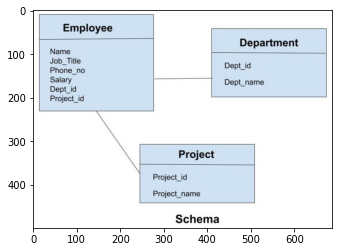

This image most likely belongs to Schematics with a 99.99 percent confidence.
This image is not a Photo 


In [28]:
isPhoto(SchematicURL)

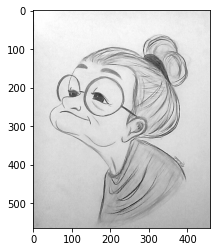



This image most likely belongs to Sketch with a 99.80 percent confidence.
This image is not a Photo 


In [37]:
isPhoto(SketchURL)

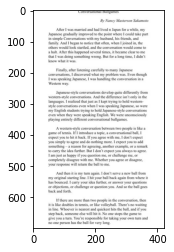



This image most likely belongs to Text with a 92.78 percent confidence.
This image is not a Photo 


In [38]:
isPhoto(TextURL)

# **Conclusion**

Nous remarquons que la précision durant les prédictions sur de nouvelles données est trés satisfaisante. Notre modèle réussit donc bien sa mission qui était de différencier les photos du reste des données du jeu de données.